# Analyse atm variables of the FHIST f09_f09 simulations (RES-CTL)

## 1. Settings

### 1.1 Import the necessary python libraries

In [1]:
from __future__ import print_function
import sys
import os
from getpass import getuser
import string
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf4
import xarray as xrµ
import pandas
import warnings

import itertools
import numpy as np
from iv_utils import *


### 1.2 General Settings

In [2]:
# set directories
outdir = '/glade/work/ivanderk/'

# Define directory where processing is done -- subject to change
procdir =  outdir + 'postprocessing/' 

# go to processing directory 
os.chdir(procdir)

# ignore all runtime warnings
warnings.filterwarnings('ignore')

### 1.3 User settings

In [3]:
# set case name
case_res   = 'f.FHIST.f09_f09_mg17.CTL'
case_nores = 'f.FHIST.f09_f09_mg17.NORES'

# set number of ensemble members
n_ens = 5

# set individual case names for reference
case_res_ind   = 'f.FHIST.f09_f09_mg17.CTL.001'
case_nores_ind   = 'f.FHIST.f09_f09_mg17.NORES.001'
case   = 'f.FHIST.f09_f09_mg17.CTL.001'

# run settings -- change this to terms directly? 
block = 'atm'  # lnd data
               # atm data
               # rof data
        
stream = 'h0'  # h0 output block
               # h1 output block
               # h2 output block
               # xtrm calculated (annual)
        
# define start and end year
spstartyear = '1979'   # spin up start year 
startyear   = '1984'   # start year, spin up excluded
endyear     = '2014'   # last year of the simulation


## Analysis of number ensemble members (detection of forced response)

## Plot 5 Members in violinplots

In [5]:
def plot_violins_enssize_response_5m(var, ax=False, ylims = False, panel_label = False):
    
    n_ens = 5
    resmask = get_resmask(threshold=0)
    # open all ensemble members and calculate temporal and spatial mean
    da_res_em = open_da_ens(var,case=case_res, mode='all').where(resmask)    
    da_nores_em = open_da_ens(var,case=case_nores, mode='all').where(resmask)
    da_res_em_mean = da_res_em.mean(dim=('time','lat','lon'))
    da_nores_em_mean = da_nores_em.mean(dim=('time','lat','lon'))

    # calculate combinations with 1 ensemble member and calculate average over those ensemble members
    mean_1_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 1))).mean(axis=1)
    mean_1_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 1))).mean(axis=1)
    [meshgrid_1_nores, meshgrid_1_res] = np.meshgrid(mean_1_nores, mean_1_res)
    delta_1m = (meshgrid_1_res - meshgrid_1_nores).flatten()

    # calculate combinations with 2 ensemble members and calculate average over those ensemble members
    mean_2_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 2))).mean(axis=1)
    mean_2_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 2))).mean(axis=1)
    [meshgrid_2_nores, meshgrid_2_res] = np.meshgrid(mean_2_nores, mean_2_res)
    delta_2m = (meshgrid_2_res - meshgrid_2_nores).flatten()
    
    print('mean_2_nores')
    print(mean_2_nores.shape)

    # calculate combinations with 3 ensemble members and calculate average over those ensemble members
    mean_3_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 3))).mean(axis=1)
    mean_3_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 3))).mean(axis=1)
    [meshgrid_3_nores, meshgrid_3_res] = np.meshgrid(mean_3_nores, mean_3_res)
    delta_3m = (meshgrid_3_res - meshgrid_3_nores).flatten()

    # calculate combinations with 4 ensemble members and calculate average over those ensemble members
    mean_4_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 4))).mean(axis=1)
    mean_4_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 4))).mean(axis=1)
    [meshgrid_4_nores, meshgrid_4_res] = np.meshgrid(mean_4_nores, mean_4_res)
    delta_4m = (meshgrid_4_res - meshgrid_4_nores).flatten()

    # calculate combinations with 3 ensemble members and calculate average over those ensemble members
    mean_5_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 5))).mean(axis=1)
    mean_5_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 5))).mean(axis=1)
    [meshgrid_5_nores, meshgrid_5_res] = np.meshgrid(mean_5_nores, mean_5_res)
    delta_5m = (meshgrid_5_res - meshgrid_5_nores).flatten()
    
    data = np.asarray([delta_1m, delta_2m, delta_3m, delta_4m, delta_5m])
    
    print(var+' range 1 ens member: '+str(delta_1m.min()) +' - '+ str(delta_1m.max()))
    print()
    # VIOLIN PLOT 
    if not ax: 
        fig , ax = plt.subplots()

    # create dummy violinplot to have white left sides
    parts1 = ax.violinplot(data, showmeans=False, showmedians=False,
            showextrema=False)
    for pc in parts1['bodies']:
        pc.set_facecolor('palegoldenrod')
        pc.set_edgecolor('darkgoldenrod')
        pc.set_alpha(1)

        # remove the left half of plot
        # get the center
        m = np.mean(pc.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further right than the center
        pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
        pc.set_color('w')   


    # this is the real violinplot
    parts2 = ax.violinplot(data, showmeans=False, showmedians=False,
            showextrema=False, widths=1)    

    for pc in parts2['bodies']:

        m = np.mean(pc.get_paths()[0].vertices[:, 0])
        # modify the paths to not go further right than the center
        pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
        pc.set_facecolor('palegoldenrod')
        pc.set_edgecolor('tan')
        pc.set_alpha(1)

    # remove the line in the fifth violinplot    
    parts2['bodies'][-1].set_edgecolor('w')

    # plot medians and IQRs
        
    # helper function
    def adjacent_values(vals, q1, q3):
        upper_adjacent_value = q3 + (q3 - q1) * 1.5
        upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

        lower_adjacent_value = q1 - (q3 - q1) * 1.5
        lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
        return lower_adjacent_value, upper_adjacent_value

    medians = []
    whiskers_min = []
    whiskers_max = []
    quartiles1 = []
    quartiles3 = []
    for ensmember in data: 
        (quartile1, median, quartile3) = np.percentile(ensmember, [25, 50, 75])
        whisker = np.array([adjacent_values(ensmember, quartile1,  quartile3)])
        whisker_min, whisker_max = whisker[:, 0], whisker[:, 1]

        medians = np.append(medians,median)
        whiskers_min =  np.append(whiskers_min, whisker_min)
        whiskers_max =  np.append(whiskers_max, whisker_max)
        quartiles1 =  np.append(quartiles1, quartile1)
        quartiles3 =  np.append(quartiles3, quartile3)


    inds = np.arange(1, len(medians) + 1.0)
    inds = inds + 0.02
    ax.scatter(inds, medians, marker='o', color='maroon', s=20, zorder=3)
    ax.vlines(inds, quartiles1, quartiles3, color='darkgoldenrod', linestyle='-', lw=4)
    #ax.vlines(inds, whiskers_min, whiskers_max, color='goldenrod', linestyle='-', lw=3)

    # do axes settings    
    ax.set_xticks([1,2,3, 4, 5])
    ax.set_xlim((0.5,5.5))
    
    if ylims != False: 
        ax.set_ylim(ylims)
    if panel_label != False:
        ax.text(0, 1.02, panel_label, color='dimgrey', fontsize=12, transform=ax.transAxes, weight = 'bold')
    
    ax.set_xlabel('Number of ensemble members')
    ax.set_ylabel(da_res_em.units); 
 
    
    if var == ('TSMN'): da_res_em.name = 'TNn'
    if var == ('TSMX'): da_res_em.name = 'TXx'
    if var == ('TREFHT'): da_res_em.name = 'T$_{2m}$'

    ax.set_title('$\Delta$ '+da_res_em.name, loc='right', size=12)
    ax.axhline(0, color='lightgray', linewidth=1)    

    return ax

mean_2_nores
(10,)
TREFHT range 1 ens member: -0.048706055 - 0.20501709

mean_2_nores
(10,)
DTR range 1 ens member: -0.1451664 - -0.07842159

mean_2_nores
(10,)
TSMX range 1 ens member: -0.2871704 - 0.008636475

mean_2_nores
(10,)
TSMN range 1 ens member: 0.11502075 - 0.44265747



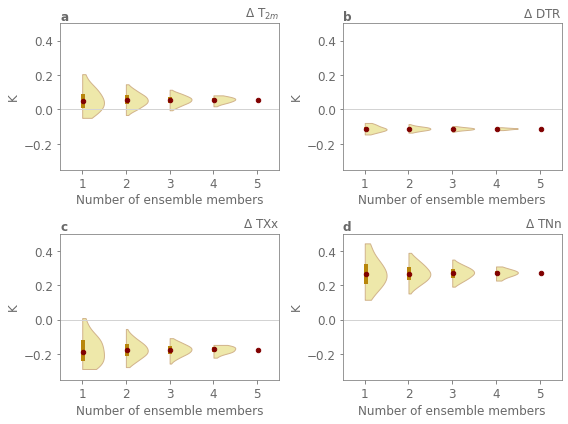

In [6]:
# 5 members
set_plot_param()
fig, axes = plt.subplots(2,2, figsize=(8,6))
ylims = [-0.35,0.5]

axes = axes.flatten()

plot_violins_enssize_response_5m('TREFHT', ax = axes[0], ylims = ylims, panel_label='a')
plot_violins_enssize_response_5m( 'DTR'  , ax = axes[1], ylims = ylims, panel_label='b')
plot_violins_enssize_response_5m( 'TSMX' , ax = axes[2], ylims = ylims, panel_label='c')
plot_violins_enssize_response_5m( 'TSMN' , ax = axes[3], ylims = ylims, panel_label='d')


fig.tight_layout()
fig.savefig('./plots/ens_size.png',  bbox_inches='tight')

### 3 ensemble members

In [9]:
# set parameters for plotting
set_plot_param()

# 3 members
def plot_enssize_response_3m(var):
    
    n_ens = 3
    resmask = get_resmask(threshold=0)
    # open all ensemble members and calculate temporal and spatial mean
    da_res_em = open_da_ens(var,case=case_res, mode='all').where(resmask)    
    da_nores_em = open_da_ens(var,case=case_nores, mode='all').where(resmask)
    da_res_em_mean = da_res_em.mean(dim=('time','lat','lon'))
    da_nores_em_mean = da_nores_em.mean(dim=('time','lat','lon'))

    # calculate combinations with 1 ensemble member and calculate average over those ensemble members
    mean_1_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 1))).mean(axis=1)
    mean_1_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 1))).mean(axis=1)
    [meshgrid_1_nores, meshgrid_1_res] = np.meshgrid(mean_1_nores, mean_1_res)
    delta_1m = (meshgrid_1_res - meshgrid_1_nores).flatten()

    # calculate combinations with 2 ensemble members and calculate average over those ensemble members
    mean_2_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 2))).mean(axis=1)
    mean_2_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 2))).mean(axis=1)
    [meshgrid_2_nores, meshgrid_2_res] = np.meshgrid(mean_2_nores, mean_2_res)
    delta_2m = (meshgrid_2_res - meshgrid_2_nores).flatten()


    # calculate combinations with 3 ensemble members and calculate average over those ensemble members
    mean_3_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 3))).mean(axis=1)
    mean_3_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 3))).mean(axis=1)
    [meshgrid_3_nores, meshgrid_3_res] = np.meshgrid(mean_3_nores, mean_3_res)
    delta_3m = (meshgrid_3_res - meshgrid_3_nores).flatten()

    # plot values per possible combination of ensemble members

    fig , ax = plt.subplots()

    ax.plot(np.ones(delta_1m.shape)* 1,delta_1m, 'ro', color='goldenrod') 
    ax.plot(np.ones(delta_2m.shape)* 2,delta_2m, 'ro', color='goldenrod') 
    ax.plot(np.ones(delta_3m.shape)* 3,delta_3m,'ro', color='goldenrod') 
    ax.set_xticks([1,2,3])
    ax.set_xlim((0.5,3.5))
    ax.set_xlabel('Number of ensemble members')
    ax.set_ylabel('$\Delta$ '+da_res_em.name+' ('+da_res_em.units+')'); 
    ax.set_title(da_res_em.long_name, loc='right', size=12)
    ax.axhline(0, color='lightgray', linewidth=1)
    
# for 5 members   
def plot_enssize_response_5m(var, ax = False):
    
    n_ens = 5
    resmask = get_resmask(threshold=0)
    # open all ensemble members and calculate temporal and spatial mean
    da_res_em = open_da_ens(var,case=case_res, mode='all')#.where(resmask)    
    da_nores_em = open_da_ens(var,case=case_nores, mode='all')#.where(resmask)
    da_res_em_mean = da_res_em.mean(dim=('time','lat','lon'))
    da_nores_em_mean = da_nores_em.mean(dim=('time','lat','lon'))

    # calculate combinations with 1 ensemble member and calculate average over those ensemble members
    mean_1_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 1))).mean(axis=1)
    mean_1_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 1))).mean(axis=1)
    [meshgrid_1_nores, meshgrid_1_res] = np.meshgrid(mean_1_nores, mean_1_res)
    delta_1m = (meshgrid_1_res - meshgrid_1_nores).flatten()

    # calculate combinations with 2 ensemble members and calculate average over those ensemble members
    mean_2_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 2))).mean(axis=1)
    mean_2_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 2))).mean(axis=1)
    [meshgrid_2_nores, meshgrid_2_res] = np.meshgrid(mean_2_nores, mean_2_res)
    delta_2m = (meshgrid_2_res - meshgrid_2_nores).flatten()


    # calculate combinations with 3 ensemble members and calculate average over those ensemble members
    mean_3_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 3))).mean(axis=1)
    mean_3_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 3))).mean(axis=1)
    [meshgrid_3_nores, meshgrid_3_res] = np.meshgrid(mean_3_nores, mean_3_res)
    delta_3m = (meshgrid_3_res - meshgrid_3_nores).flatten()

    # calculate combinations with 4 ensemble members and calculate average over those ensemble members
    mean_4_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 4))).mean(axis=1)
    mean_4_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 4))).mean(axis=1)
    [meshgrid_4_nores, meshgrid_4_res] = np.meshgrid(mean_4_nores, mean_4_res)
    delta_4m = (meshgrid_4_res - meshgrid_4_nores).flatten()

    # calculate combinations with 3 ensemble members and calculate average over those ensemble members
    mean_5_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 5))).mean(axis=1)
    mean_5_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 5))).mean(axis=1)
    [meshgrid_5_nores, meshgrid_5_res] = np.meshgrid(mean_5_nores, mean_5_res)
    delta_5m = (meshgrid_5_res - meshgrid_5_nores).flatten()

    # plot values per possible combination of ensemble members
    if not ax: 
        fig , ax = plt.subplots()

    ax.plot(np.ones(delta_1m.shape)* 1,delta_1m, 'ro', color='goldenrod') 
    ax.plot(np.ones(delta_2m.shape)* 2,delta_2m, 'ro', color='goldenrod') 
    ax.plot(np.ones(delta_3m.shape)* 3,delta_3m,'ro', color='goldenrod') 
    ax.plot(np.ones(delta_4m.shape)* 4,delta_4m,'ro', color='goldenrod') 
    ax.plot(np.ones(delta_5m.shape)* 5,delta_5m,'ro', color='goldenrod') 

    ax.set_xticks([1,2,3, 4, 5])
    ax.set_xlim((0.5,5.5))
    ax.set_xlabel('Number of ensemble members')
    ax.set_ylabel('$\Delta$ '+da_res_em.name+' ('+da_res_em.units+')'); 
    ax.set_title(da_res_em.long_name, loc='right', size=12)
    ax.axhline(0, color='lightgray', linewidth=1)    

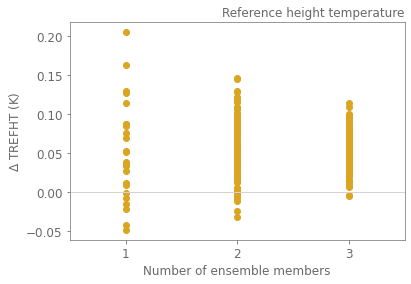

In [10]:
plot_enssize_response_3m('TREFHT')

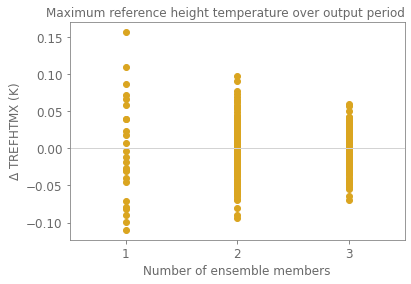

In [11]:
plot_enssize_response_3m('TREFHTMX')

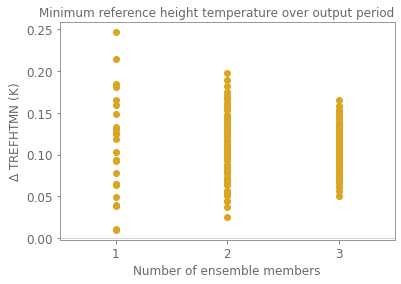

In [12]:
plot_enssize_response_3m('TREFHTMN')

In [ ]:
plot_enssize_response_3m('PRECT')

## Plot 5 Members

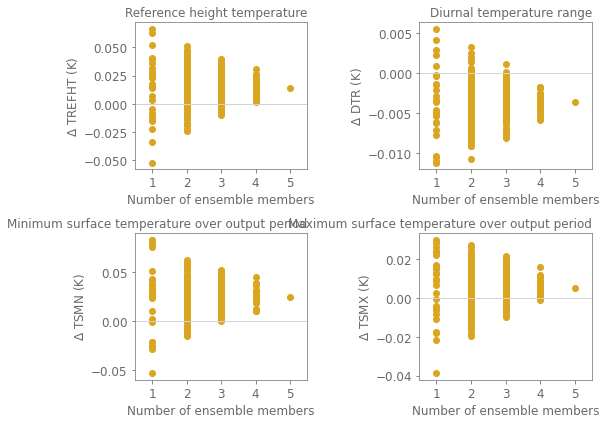

In [136]:
# 5 members
fig, axes = plt.subplots(2,2, figsize=(8,6))

axes = axes.flatten()
plot_enssize_response_5m('TREFHT', ax = axes[0])
plot_enssize_response_5m( 'TSMN', ax = axes[2])
plot_enssize_response_5m( 'TSMX', ax = axes[3])
plot_enssize_response_5m( 'DTR', ax = axes[1])


fig.tight_layout()

mean_2_nores
(10,)
TREFHT range 1 ens member: -0.048706055 - 0.20501709



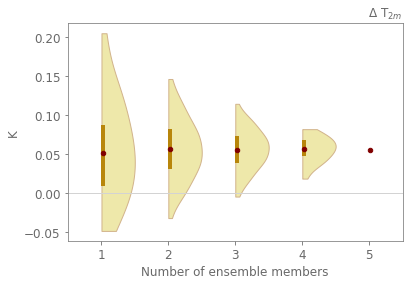

In [9]:
var ='TREFHT'
ax=False
ylims = False
panel_label = False
    
n_ens = 5
resmask = get_resmask(threshold=0)
# open all ensemble members and calculate temporal and spatial mean
da_res_em = open_da_ens(var,case=case_res, mode='all').where(resmask)    
da_nores_em = open_da_ens(var,case=case_nores, mode='all').where(resmask)
da_res_em_mean = da_res_em.mean(dim=('time','lat','lon'))
da_nores_em_mean = da_nores_em.mean(dim=('time','lat','lon'))

# calculate combinations with 1 ensemble member and calculate average over those ensemble members
mean_1_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 1))).mean(axis=1)
mean_1_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 1))).mean(axis=1)
[meshgrid_1_nores, meshgrid_1_res] = np.meshgrid(mean_1_nores, mean_1_res)
delta_1m = (meshgrid_1_res - meshgrid_1_nores).flatten()

# calculate combinations with 2 ensemble members and calculate average over those ensemble members
mean_2_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 2))).mean(axis=1)
mean_2_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 2))).mean(axis=1)
[meshgrid_2_nores, meshgrid_2_res] = np.meshgrid(mean_2_nores, mean_2_res)
delta_2m = (meshgrid_2_res - meshgrid_2_nores).flatten()

print('mean_2_nores')
print(mean_2_nores.shape)

# calculate combinations with 3 ensemble members and calculate average over those ensemble members
mean_3_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 3))).mean(axis=1)
mean_3_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 3))).mean(axis=1)
[meshgrid_3_nores, meshgrid_3_res] = np.meshgrid(mean_3_nores, mean_3_res)
delta_3m = (meshgrid_3_res - meshgrid_3_nores).flatten()

# calculate combinations with 4 ensemble members and calculate average over those ensemble members
mean_4_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 4))).mean(axis=1)
mean_4_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 4))).mean(axis=1)
[meshgrid_4_nores, meshgrid_4_res] = np.meshgrid(mean_4_nores, mean_4_res)
delta_4m = (meshgrid_4_res - meshgrid_4_nores).flatten()

# calculate combinations with 3 ensemble members and calculate average over those ensemble members
mean_5_nores = np.asarray(list(itertools.combinations(da_nores_em_mean.values, 5))).mean(axis=1)
mean_5_res = np.asarray(list(itertools.combinations(da_res_em_mean.values, 5))).mean(axis=1)
[meshgrid_5_nores, meshgrid_5_res] = np.meshgrid(mean_5_nores, mean_5_res)
delta_5m = (meshgrid_5_res - meshgrid_5_nores).flatten()

data = np.asarray([delta_1m, delta_2m, delta_3m, delta_4m, delta_5m])

print(var+' range 1 ens member: '+str(delta_1m.min()) +' - '+ str(delta_1m.max()))
print()
# VIOLIN PLOT 
if not ax: 
    fig , ax = plt.subplots()

# create dummy violinplot to have white left sides
parts1 = ax.violinplot(data, showmeans=False, showmedians=False,
        showextrema=False)
for pc in parts1['bodies']:
    pc.set_facecolor('palegoldenrod')
    pc.set_edgecolor('darkgoldenrod')
    pc.set_alpha(1)

    # remove the left half of plot
    # get the center
    m = np.mean(pc.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
    pc.set_color('w')   


# this is the real violinplot
parts2 = ax.violinplot(data, showmeans=False, showmedians=False,
        showextrema=False, widths=1)    

for pc in parts2['bodies']:

    m = np.mean(pc.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
    pc.set_facecolor('palegoldenrod')
    pc.set_edgecolor('tan')
    pc.set_alpha(1)

# remove the line in the fifth violinplot    
parts2['bodies'][-1].set_edgecolor('w')

# plot medians and IQRs

# helper function
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

medians = []
whiskers_min = []
whiskers_max = []
quartiles1 = []
quartiles3 = []
for ensmember in data: 
    (quartile1, median, quartile3) = np.percentile(ensmember, [25, 50, 75])
    whisker = np.array([adjacent_values(ensmember, quartile1,  quartile3)])
    whisker_min, whisker_max = whisker[:, 0], whisker[:, 1]

    medians = np.append(medians,median)
    whiskers_min =  np.append(whiskers_min, whisker_min)
    whiskers_max =  np.append(whiskers_max, whisker_max)
    quartiles1 =  np.append(quartiles1, quartile1)
    quartiles3 =  np.append(quartiles3, quartile3)


inds = np.arange(1, len(medians) + 1.0)
inds = inds + 0.02
ax.scatter(inds, medians, marker='o', color='maroon', s=20, zorder=3)
ax.vlines(inds, quartiles1, quartiles3, color='darkgoldenrod', linestyle='-', lw=4)
#ax.vlines(inds, whiskers_min, whiskers_max, color='goldenrod', linestyle='-', lw=3)

# do axes settings    
ax.set_xticks([1,2,3, 4, 5])
ax.set_xlim((0.5,5.5))

if ylims != False: 
    ax.set_ylim(ylims)
if panel_label != False:
    ax.text(0, 1.02, panel_label, color='dimgrey', fontsize=12, transform=ax.transAxes, weight = 'bold')

ax.set_xlabel('Number of ensemble members')
ax.set_ylabel(da_res_em.units); 


if var == ('TSMN'): da_res_em.name = 'TNn'
if var == ('TSMX'): da_res_em.name = 'TXx'
if var == ('TREFHT'): da_res_em.name = 'T$_{2m}$'

ax.set_title('$\Delta$ '+da_res_em.name, loc='right', size=12)
ax.axhline(0, color='lightgray', linewidth=1)    


In [27]:
delta_2m.shape

(100,)